In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from matplotlib import ticker
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings

# options
warnings.filterwarnings('ignore')

In [39]:
train = pd.read_csv('../../1_variant_dna_sequence_mutation_prediction/input/train.csv')
test = pd.read_csv('../../1_variant_dna_sequence_mutation_prediction/input/test.csv')

In [40]:
train.head()

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,M,N,O,P,Q,R,S,T,U,mutation
0,0,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,2,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
2,5,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.524760,0.580085,0.301498,0.261055,0.193988,0.935688,0.685868,0.277694,0.428115,0
3,7,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATTCCATATTTT,AAATCAGCTAAA,TAACATACAGAG,TAACATACAGAG,...,0.943545,0.209744,0.670577,0.772650,0.845751,0.507320,0.927204,0.605755,0.454155,1
4,9,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,GATCGTAGCTAA,GATCGTAGCTAA,ATTCCATATTTT,AAATCAGCTAAA,ATTCCATATTTT,TAACATACAGAG,...,0.397622,0.506096,0.200673,0.734145,0.521673,0.365571,0.416094,0.584799,0.447149,1


In [41]:
print(f"Features Space: {len(train.columns)}\n# of Observations: {len(train)}\nTarget variables options: {train.mutation.nunique()}"
      f"\n# of Continous features: {len([col for col in train.select_dtypes(exclude=object).columns if col not in ['ID', 'mutation']])}"
      f"\n# of Discrete features: {len([col for col in train.select_dtypes(exclude='number', include='object').columns if col not in ['ID', 'mutation']])}")

Features Space: 32
# of Observations: 180000
Target variables options: 2
# of Continous features: 21
# of Discrete features: 9


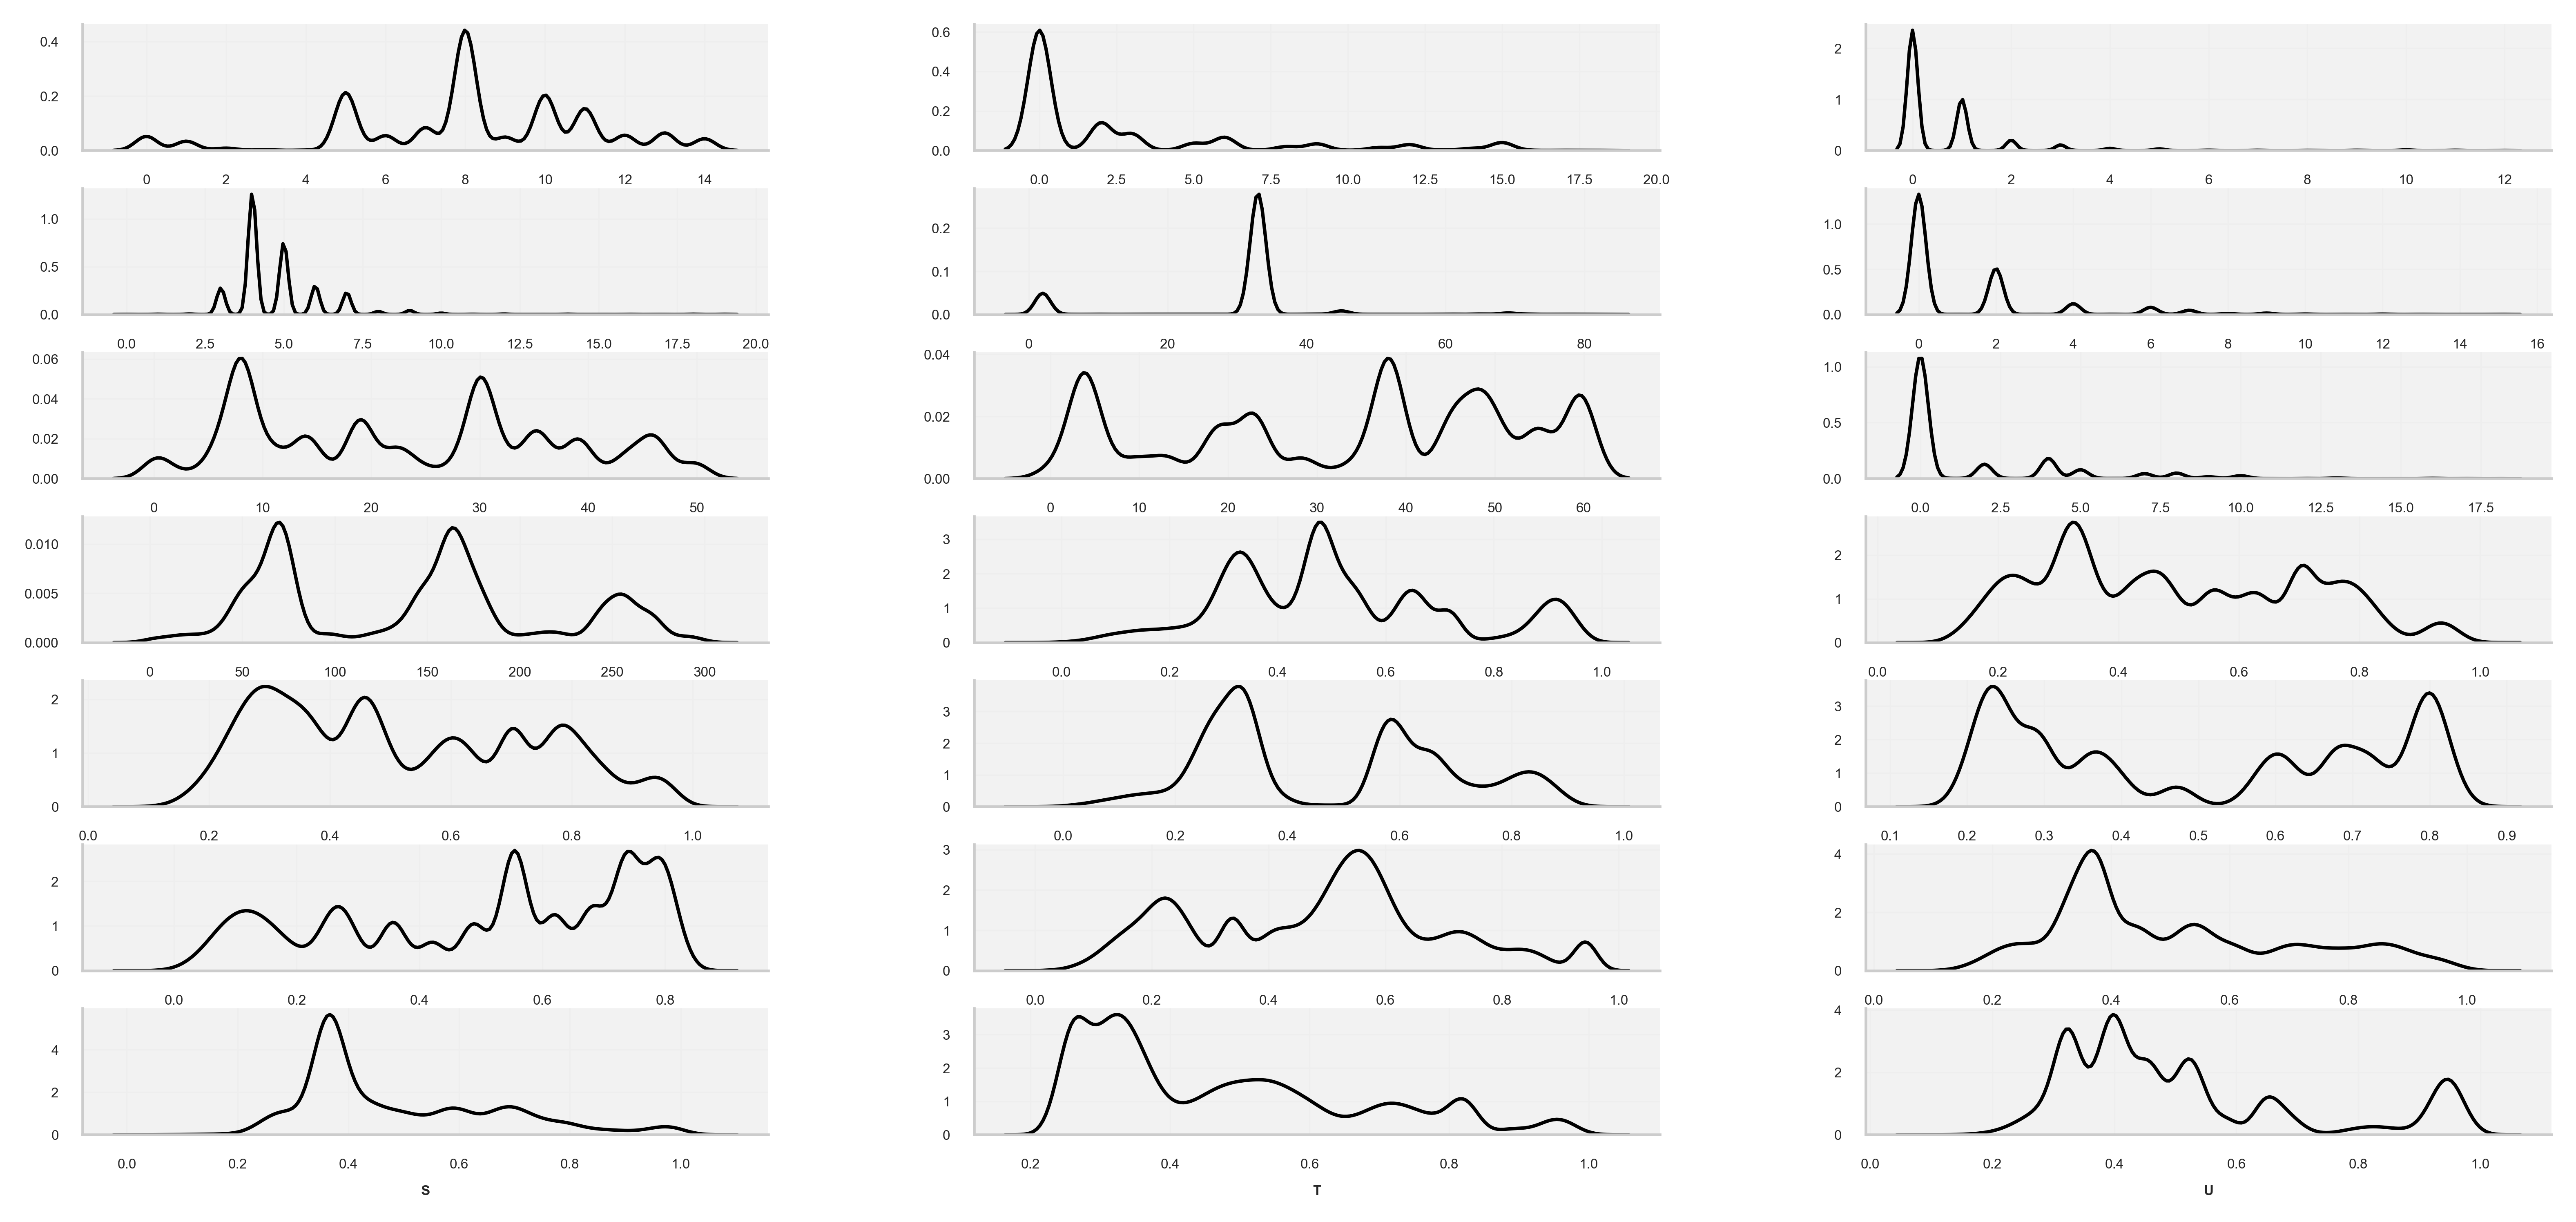

In [42]:
# features distribution of continious variables in training data

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(13, 6), facecolor='#ffffff')
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.3, hspace=0.3)
background_color = "#f2f2f2"

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

features_num = list([col for col in train.select_dtypes(exclude=object).columns if col not in ['ID', 'mutation']])

run_no = 0
for col in features_num:
    sns.kdeplot(ax=locals()["ax"+str(run_no)], x=train[col], zorder=2, alpha=1, linewidth=1, color='#000000')
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    locals()["ax"+str(run_no)].set_ylabel('')
    locals()["ax"+str(run_no)].set_xlabel(col, fontsize=4, fontweight='bold')
    locals()["ax"+str(run_no)].tick_params(labelsize=4, width=0.5)
    locals()["ax"+str(run_no)].xaxis.offsetText.set_fontsize(4)
    locals()["ax"+str(run_no)].yaxis.offsetText.set_fontsize(4)
    run_no += 1

plt.show()

<Figure size 1000x700 with 0 Axes>

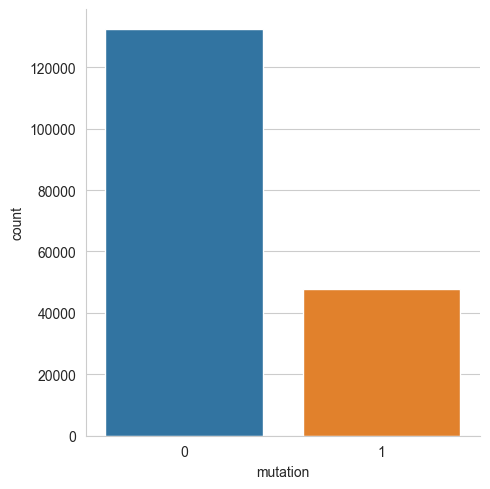

In [43]:
# distribution of the target variable
plt.rcParams['figure.dpi'] = 100
fig = plt.figure(figsize=(10, 7), facecolor='#f6f5f5')
background_color = "#dcdada"
fig = sns.catplot(x="mutation",data=train, kind="count")

In [44]:
train.mutation.value_counts(normalize=True)

0    0.7351
1    0.2649
Name: mutation, dtype: float64

In [45]:
# Encoding the labels
le=LabelEncoder()

for col in train.drop('ID',axis=1).columns:
    if train[col].dtypes == object:
        train[col]= le.fit_transform(train[col])


for col in test.drop('ID',axis=1).columns:
    if test[col].dtypes == object:
        test[col]= le.fit_transform(test[col])

# Preprocessing and encoding
def encoder(x_train, x_test):
    le = LabelEncoder()
    r = le.fit_transform(x_train)
    r2 = le.transform(x_test)
    return r, r2


features_cat = [col for col in train.columns if col in train.select_dtypes(include=object).columns]
features = [col for col in train.columns if col not in ['ID', 'mutation']]

print(f'total features: {len(features)}')
print(features)

total features: 30
['sequence1', 'sequence2', 'sequence3', 'sequence4', 'sequence5', 'sequence6', 'sequence7', 'sequence8', 'sequence9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']


In [46]:
train.head()

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,M,N,O,P,Q,R,S,T,U,mutation
0,0,0,0,0,0,0,0,1,1,0,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,2,0,0,1,0,0,0,1,1,0,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
2,5,0,0,0,0,0,0,1,1,0,...,0.524760,0.580085,0.301498,0.261055,0.193988,0.935688,0.685868,0.277694,0.428115,0
3,7,0,0,0,0,0,1,0,3,3,...,0.943545,0.209744,0.670577,0.772650,0.845751,0.507320,0.927204,0.605755,0.454155,1
4,9,0,1,0,1,1,1,0,1,3,...,0.397622,0.506096,0.200673,0.734145,0.521673,0.365571,0.416094,0.584799,0.447149,1


In [47]:
test.head()

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,L,M,N,O,P,Q,R,S,T,U
0,1,0,0,1,0,1,1,0,1,0,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
1,3,0,0,0,0,0,0,1,1,0,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
2,4,0,0,0,0,1,0,0,1,0,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960
3,6,0,0,0,0,1,1,1,1,0,...,0.707840,0.678466,0.747125,0.678212,0.553609,0.281719,0.768782,0.688580,0.320699,0.642256
4,8,1,0,0,0,0,0,1,1,0,...,0.664718,0.635195,0.672264,0.561127,0.419873,0.508550,0.673267,0.356103,0.471519,0.499554


In [ ]:
#building corr with target feature
Corr = train.drop('ID',axis=1).select_dtypes(exclude=["object"]).corr()
abs_corr_on_mutation = abs(Corr[['mutation']].copy())
abs_corr_on_mutation.drop('mutation', axis=0, inplace=True)
abs_corr_on_mutation.sort_values(by='mutation', ascending=False).plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=45)
plt.show()

In [52]:
X_train = train.drop(["mutation","ID"], axis=1)
Y_train = train["mutation"]

In [53]:
X_train.shape,Y_train.shape

((180000, 30), (180000,))

In [54]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(test.drop('ID',axis=1))

In [55]:
X_train

array([[-0.58730709, -0.39916247, -0.40952284, ...,  1.83034532,
         2.54667322,  0.7767064 ],
       [-0.58730709, -0.39916247,  2.44186626, ..., -0.42090212,
        -0.91054814,  0.20406278],
       [-0.58730709, -0.39916247, -0.40952284, ...,  1.10748142,
        -0.9876909 , -0.39254864],
       ...,
       [-0.58730709,  2.50524553, -0.40952284, ..., -0.63491577,
         0.24815794, -0.27439779],
       [ 1.70268676, -0.39916247, -0.40952284, ...,  1.07709951,
        -0.77809649, -0.84634979],
       [-0.58730709, -0.39916247, -0.40952284, ...,  1.87728066,
        -0.71607091,  2.28451308]])

In [56]:
X_test

array([[-0.58730709, -0.39916247,  2.44186626, ..., -0.49325563,
         2.35332029, -0.06992635],
       [-0.58730709, -0.39916247, -0.40952284, ...,  0.81584982,
         1.49410618,  2.09606272],
       [-0.58730709, -0.39916247, -0.40952284, ..., -0.76282341,
        -0.57944568, -0.88009233],
       ...,
       [-0.58730709, -0.39916247, -0.40952284, ...,  1.09553334,
        -1.04963409, -0.4827799 ],
       [-0.58730709, -0.39916247,  2.44186626, ..., -0.37876966,
        -0.0783035 , -0.96098425],
       [-0.58730709, -0.39916247, -0.40952284, ...,  1.10315291,
         2.45682933, -0.07304883]])

In [57]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [58]:
X_train

array([[ 4.10332853, -0.76580187],
       [-0.93026135, -2.83709633],
       [ 0.75767438, -1.25616723],
       ...,
       [-1.12831327,  3.23565835],
       [ 0.25715272, -0.57952775],
       [ 4.71926001, -0.93399672]])

In [59]:
X_test

array([[-0.72131763, -0.04841105],
       [ 5.06207251, -1.44677517],
       [-2.56488239,  0.08243543],
       ...,
       [-1.33639379,  2.72972407],
       [-2.12927402, -1.75878856],
       [ 3.05966825,  1.44144355]])

In [60]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
pred = random_forest.predict(X_test)

In [61]:
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

99.99

In [62]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train, random_forest.predict_proba(X_train)[:, 1])

0.9999999812971144

In [ ]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py